# Fake Review Detection

In [200]:
# Importing necessary libraries for the project
# Utilities
import re  
import numpy as np  
import pandas as pd  
import pickle

# Data Visualization
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import matplotlib.pyplot as plt

# Plotting
import seaborn as sns  
from wordcloud import WordCloud  

# Natural Language Toolkit
from nltk.stem import SnowballStemmer  
from nltk.stem import WordNetLemmatizer  

# Machine Learning
from sklearn.svm import LinearSVC  
from sklearn.naive_bayes import BernoulliNB  
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score  

# Set log
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [201]:
review_data = pd.read_csv('fake reviews dataset.csv')

In [202]:
review_data.head()

category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                                                                   text_  
0            Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty  
1       love it, a great upgrade from the original.  I've had mine for a couple of years  
2                    This pillow saved my back. I love the look and feel of this pillow.  
3      Missing information on how to use it, but it is a great product for the price!  I  
4  Very nice set. Good quality. We have had the set for two months now and have not been

## General Exploratory Data Analysis (EDA)

In [203]:
review_data.shape

(40432, 4)

In [204]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [205]:
review_data.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [206]:
duplicated_rows = review_data[review_data.duplicated(keep=False)]
duplicated_rows

category  rating label  \
6018          Sports_and_Outdoors_5     5.0    CG   
6025          Sports_and_Outdoors_5     5.0    CG   
6706          Sports_and_Outdoors_5     5.0    CG   
6708          Sports_and_Outdoors_5     5.0    CG   
12289               Movies_and_TV_5     5.0    CG   
12548               Movies_and_TV_5     5.0    CG   
19638                Pet_Supplies_5     5.0    CG   
19802                Pet_Supplies_5     5.0    CG   
19803                Pet_Supplies_5     5.0    CG   
20242                Pet_Supplies_5     5.0    CG   
22294                Pet_Supplies_5     5.0    OR   
22305                Pet_Supplies_5     5.0    OR   
26399                Kindle_Store_5     5.0    CG   
26444                Kindle_Store_5     5.0    CG   
27232                Kindle_Store_5     5.0    CG   
27233                Kindle_Store_5     5.0    CG   
29091                       Books_5     5.0    CG   
29203                       Books_5     5.0    CG   
33208              Toys_and_Games_5     5.0    CG   
33602              Toys_and_Games_5     5.0    CG   
34788              Toys_and_Games_5     5.0    CG   
34795              Toys_and_Games_5     5.0    CG   
37296  Clothing_Shoes_and_Jewelry_5     5.0    CG   
37543  Clothing_Shoes_and_Jewelry_5     5.0    CG   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text_  
6018                                                                                                                                                                                                                                                                                                                                                                            This is a really good starter kit, with lots of tools and a lot of options. The other two I had to replace, both with different basic tools, were great.  
6025                                                                                                                                                                                                                                                                                                                                                                            This is a really good starter kit, with lots of tools and a lot of options. The other two I had to replace, both with different basic tools, were great.  
6706                                                                                                                                                                                                                                                  Great, no complaints. Comfortable, phone fits in the pocket, comfortable, it fits my thumb well.  I highly recommend.  The plastic part is also very light and easy to take off and on.  I would highly recommend this product.I use this as a hiking pack.  The first time I used  
6708                                                                                                                                                                                                                                                  Great, no complaints. Comfortable, phone fits in the pocket, comfortable, it fits my thumb well.  I highly recommend.  The plastic part is also very light and easy to take off and on.  I would highly recommend this product.I use this as a hiking pack.  The first time I used  
12289                                                                                 

In [207]:
for column in ['label', 'rating', 'category']:
    unique_values = review_data[column].unique()
    print(f"Unique {column} values: {unique_values}")
    print()

Unique label values: ['CG' 'OR']

Unique rating values: [5. 1. 3. 2. 4.]

Unique category values: ['Home_and_Kitchen_5' 'Sports_and_Outdoors_5' 'Electronics_5'
 'Movies_and_TV_5' 'Tools_and_Home_Improvement_5' 'Pet_Supplies_5'
 'Kindle_Store_5' 'Books_5' 'Toys_and_Games_5'
 'Clothing_Shoes_and_Jewelry_5']



## Data Cleansing

In [208]:
# Remove _ values from the category column
review_data['category'] = review_data['category'].str.replace('_', ' ')

# Remove the number 5 and leading/trailing whitespace from the category column
review_data['category'] = review_data['category'].str.replace('5', '').str.strip()

In [209]:
# Replace the label values in the label column
review_data['label'] = review_data['label'].replace({'CG': 'Fake', 'OR': 'Original'})

In [210]:
# Change column text_ into review
review_data.rename(columns={'text_': 'review'}, inplace=True)

## Visualization

### Fake/Original Count

In [211]:
# Get the unique label values in the label column of review_data
labels = review_data['label'].unique()

# Calculate the count of each label value in review_data using a list comprehension
sizes = [len(review_data[review_data['label'] == label]) for label in labels]

# Use plotly express to create a pie chart with labels, percentages, and legend
fig = px.pie(values=sizes, names=labels, title='Label Count', hole=0.5)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    title=dict(x=0.5),
    legend=dict(orientation='h', yanchor='bottom', y=1.1, xanchor='center', x=0.5)
)

# Display the pie chart
fig.show()

### Rating Distribution

In [212]:
def plot_distribution(data, column, label):
    # Filter the data by label
    filtered_data = data[data['label'] == label]

    # Get the unique label values in the filtered data
    unique_labels = filtered_data['label'].unique()

    # Create a pie chart of the rating distribution
    sizes = [len(filtered_data[filtered_data[column] == rating]) for rating in filtered_data[column].unique()]
    fig = px.pie(values=sizes, names=filtered_data[column].unique(), title=f'{label} {column} Distribution', hole=0.5)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(title=dict(x=0.5))
    fig.show()

    # Create a histogram of the column
    fig = px.histogram(filtered_data, x=column, nbins=5, title=f'{column} Distribution for {label} Reviews')
    fig.update_layout(xaxis_title=column, yaxis_title='Count')
    fig.show()

    # Create a horizontal boxplot of the column
    fig = px.box(filtered_data, x=column, orientation='h', title=f'{column} Distribution for {label} Reviews')
    fig.update_layout(xaxis_title=column, yaxis_title='')
    fig.show()

In [213]:
# Plot the distribution of the rating column for fake reviews
plot_distribution(review_data, 'rating', 'Fake')

In [214]:
# Plot the distribution of the rating column original reviews
plot_distribution(review_data, 'rating', 'Original')

In [215]:
# Make a pie chart showing distribution of categories
sizes = [len(review_data[review_data['category'] == category]) for category in review_data['category'].unique()]
fig = px.pie(values=sizes, names=review_data['category'].unique(), title='Category Distribution', hole=0.5)
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title=dict(x=0.5))
fig.show()

## Preprocessing

In [216]:
# We only need the label and review columns
review_data = review_data[['label', 'review']]
review_data.head()

label  \
0  Fake   
1  Fake   
2  Fake   
3  Fake   
4  Fake   

                                                                                  review  
0            Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty  
1       love it, a great upgrade from the original.  I've had mine for a couple of years  
2                    This pillow saved my back. I love the look and feel of this pillow.  
3      Missing information on how to use it, but it is a great product for the price!  I  
4  Very nice set. Good quality. We have had the set for two months now and have not been

In [217]:
from nltk.corpus import stopwords

# Load the English stop words
stop_words = stopwords.words("english")

# Create a Snowball stemmer for English
stemmer = SnowballStemmer("english")

In [218]:
# Define a regular expression to match special characters, links, and user mentions
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove special characters, links, and user mentions
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                # Stem the token if stem=True
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    # Join the tokens back into a string
    return " ".join(tokens)

In [219]:
# Apply it to the review column of review_data
review_data['review'] = review_data['review'].apply(lambda x: preprocess(x))

In [220]:
def wordcloud_maker(data, title=None, max_words=1000, width=1600, height=800, collocations=False):
    # Create a WordCloud object with the specified parameters
    wordcloud = WordCloud(width=width, 
                          height=height, 
                          max_words=max_words, 
                          background_color="white", 
                          stopwords=stop_words, 
                          min_font_size=10, 
                          collocations=collocations).generate(str(data))
    
    # Plot the WordCloud image                        
    plt.figure(figsize=(20, 20), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

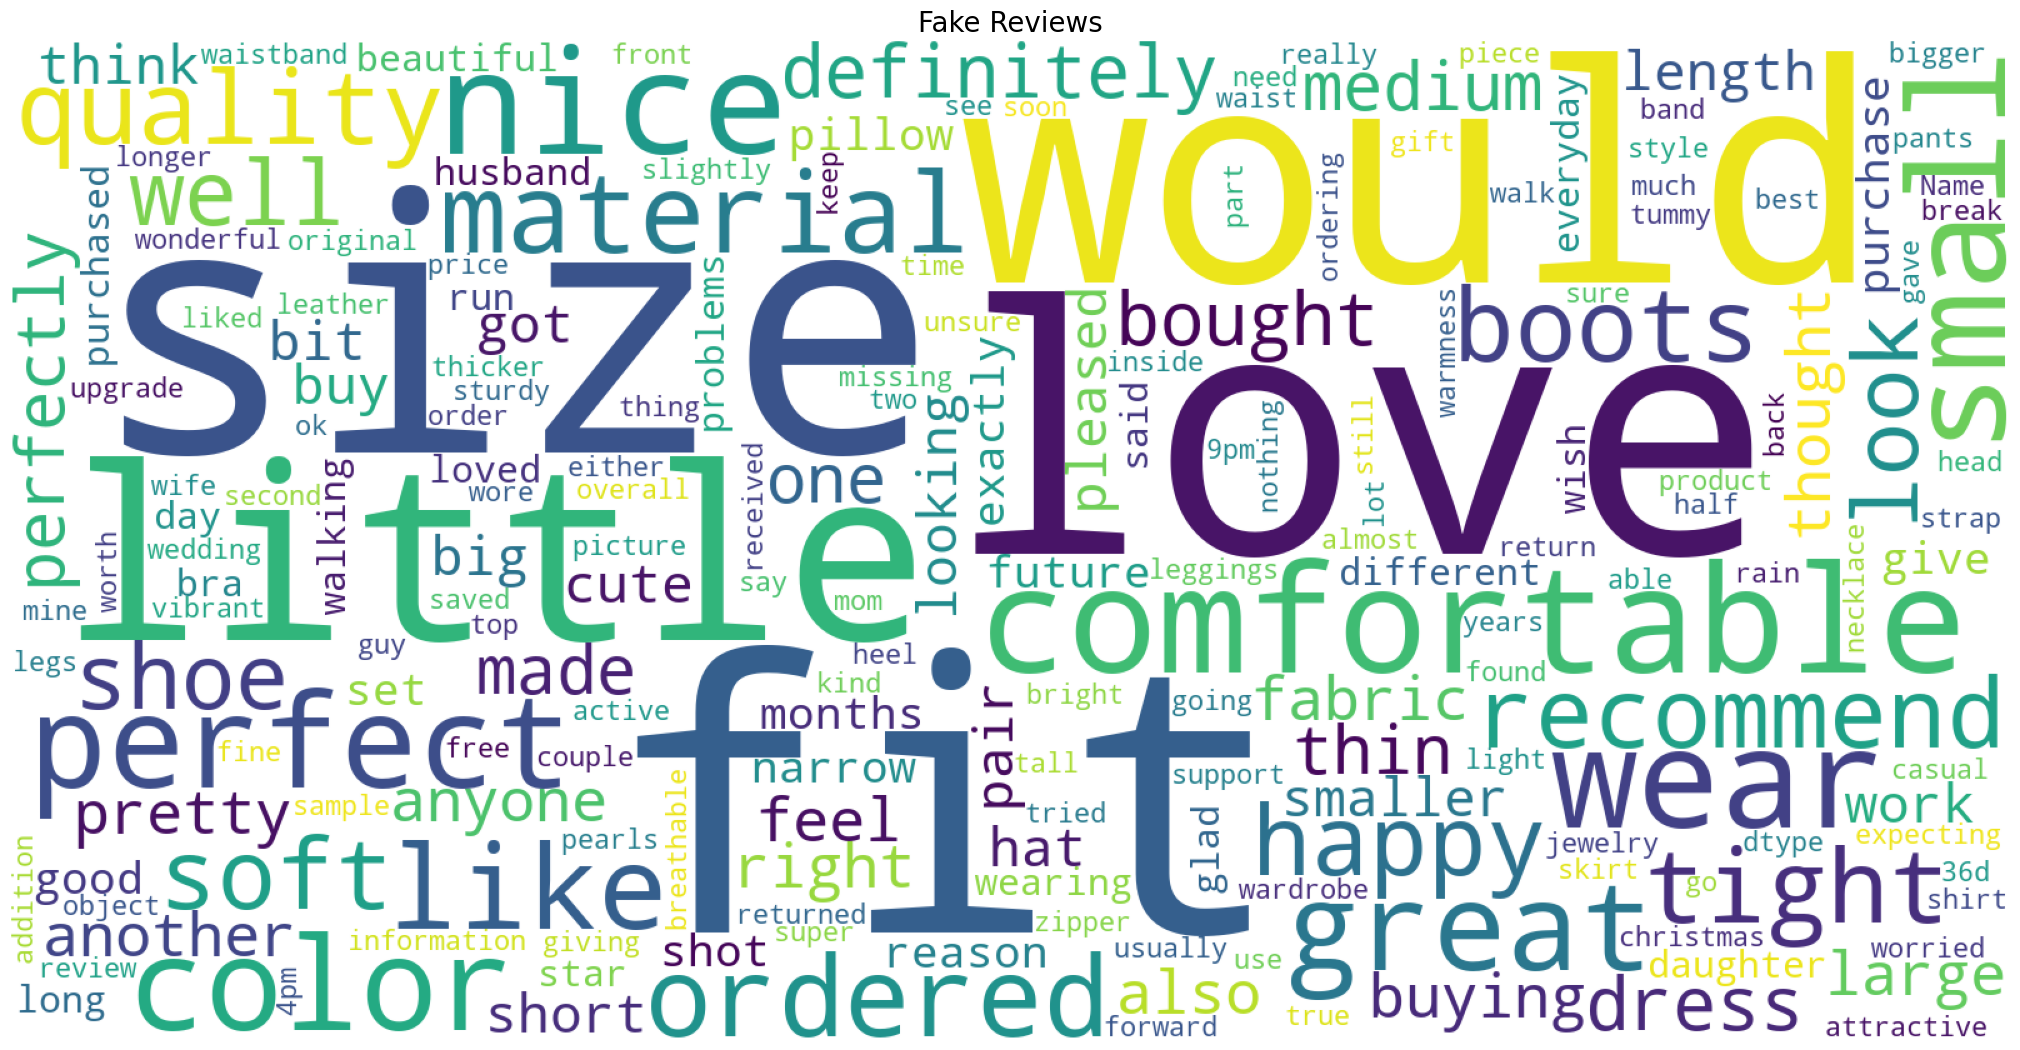

In [221]:
# Create a WordCloud of the fake reviews
wordcloud_maker(review_data[review_data['label'] == 'Fake']['review'], title='Fake Reviews')

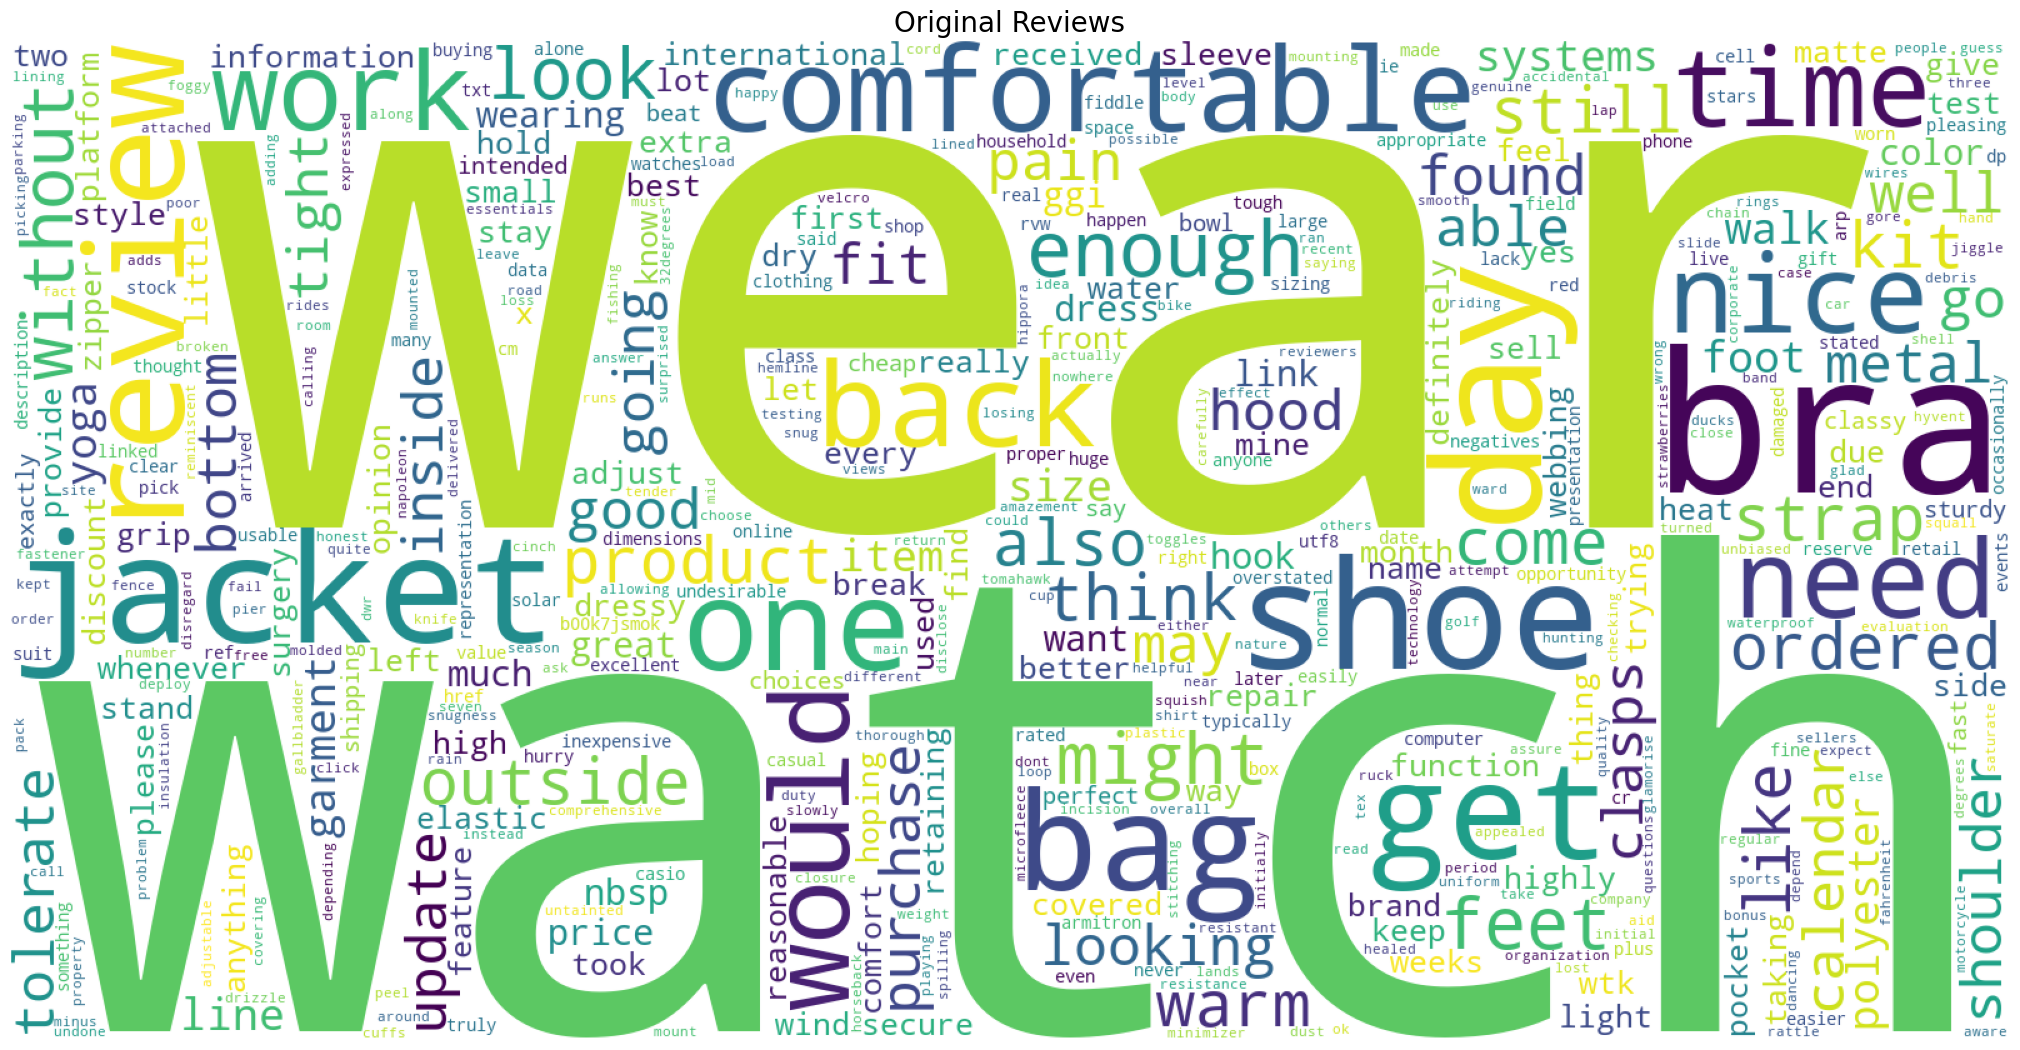

In [222]:
# Create a WordCloud of the original reviews
wordcloud_maker(review_data[review_data['label'] == 'Original']['review'], title='Original Reviews')

## Splitting Data

In [223]:
# split the data into training and test sets
X = review_data['review']
y = review_data['label']

X_train, X_test, y_train, y_test = train_test_split(review_data['review'], review_data['label'], test_size=0.2, random_state=42)

## Vectorize

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the object with the training data reviews
vectorizer.fit(X_train)

# Transform the training data reviews
X_train = vectorizer.transform(X_train)

# Transform the test data reviews
X_test = vectorizer.transform(X_test)

# Vectorize the labels
y_train = y_train.map({'Fake': 1, 'Original': 0})
y_test = y_test.map({'Fake': 1, 'Original': 0})

# Save the vectorizer
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

In [225]:
# set validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (25876, 36698)
X_val shape: (6469, 36698)
X_test shape: (8087, 36698)
y_train shape: (25876,)
y_val shape: (6469,)
y_test shape: (8087,)


## Model Building

In [226]:
def model_train_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and get classification report
    y_pred = model.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # Get the accuracy score of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Get the confusion matrix of the model
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n{cm}")
    
    # Calculate the percentages and labels for the confusion matrix
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Fake', 'Original'], yticklabels=['Fake', 'Original'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    with open(f"{model_name}.pkl", 'wb') as f:
        pickle.dump(model, f)

### SVM

Classification Report for svm:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4071
           1       0.88      0.88      0.88      4016

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087

Accuracy: 0.8811673055521206
Confusion Matrix: 
[[3595  476]
 [ 485 3531]]


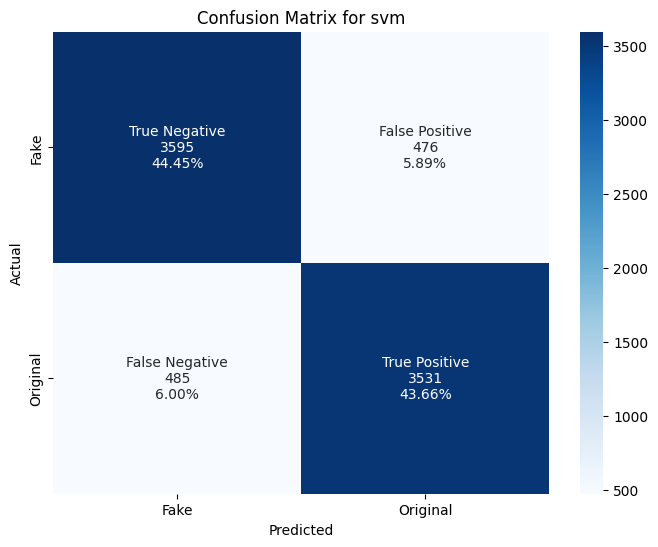

In [227]:
# Create a LinearSVC model
svm = LinearSVC()

# Train and evaluate the model
model_train_evaluate(svm, X_train, y_train, X_test, y_test, "svm")

### Naive Bayes

Classification Report for nb:
              precision    recall  f1-score   support

           0       0.93      0.50      0.65      4071
           1       0.65      0.96      0.78      4016

    accuracy                           0.73      8087
   macro avg       0.79      0.73      0.71      8087
weighted avg       0.79      0.73      0.71      8087

Accuracy: 0.7280821070854457
Confusion Matrix: 
[[2028 2043]
 [ 156 3860]]


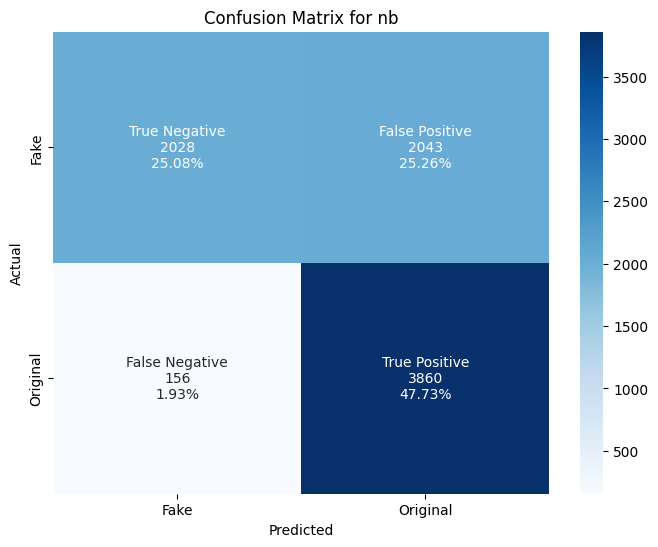

In [228]:
from sklearn.naive_bayes import BernoulliNB

# Create a MultinomialNB model
nb = BernoulliNB()

# Evaluate the model
model_train_evaluate(nb, X_train, y_train, X_test, y_test, "nb")

### Logistic Regression

Classification Report for lr:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4071
           1       0.89      0.85      0.87      4016

    accuracy                           0.87      8087
   macro avg       0.88      0.87      0.87      8087
weighted avg       0.88      0.87      0.87      8087

Accuracy: 0.8747372325955237
Confusion Matrix: 
[[3655  416]
 [ 597 3419]]


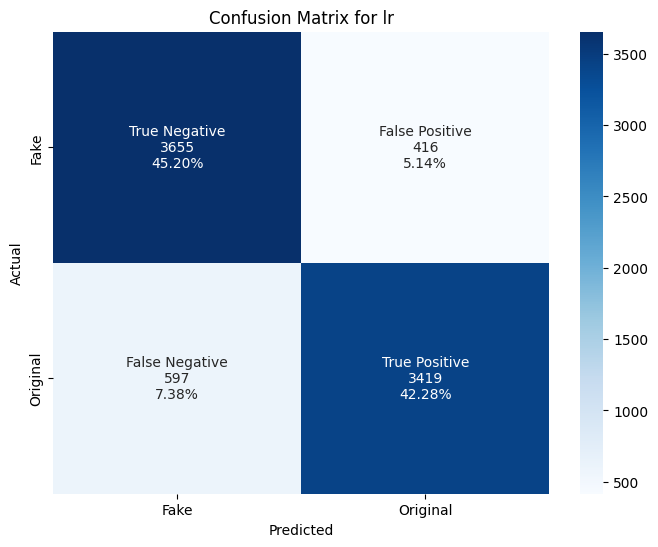

In [229]:
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression model
lr = LogisticRegression(solver='saga')

# Evaluate the model
model_train_evaluate(lr, X_train, y_train, X_test, y_test, "lr")

### Decision Tree Classifier

Classification Report for dt:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      4071
           1       0.73      0.77      0.75      4016

    accuracy                           0.75      8087
   macro avg       0.75      0.75      0.75      8087
weighted avg       0.75      0.75      0.75      8087

Accuracy: 0.7474959812044021
Confusion Matrix: 
[[2939 1132]
 [ 910 3106]]


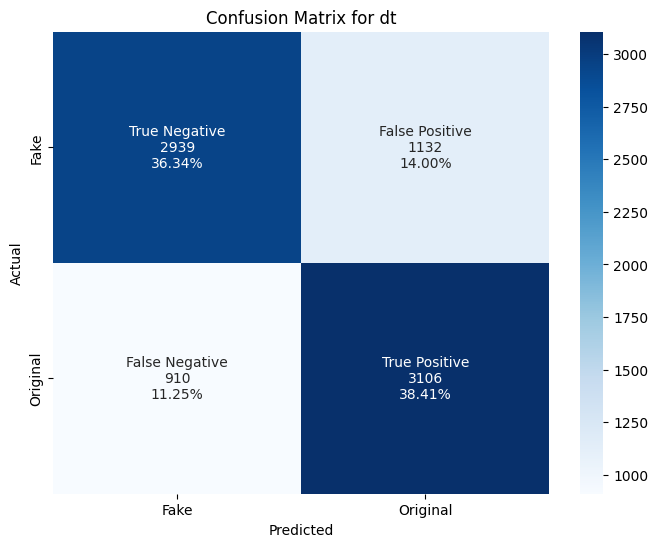

In [230]:
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier model
dt = DecisionTreeClassifier()

# Evaluate the model
model_train_evaluate(dt, X_train, y_train, X_test, y_test, "dt")

### Random Forest Classifier

Classification Report for rf:
              precision    recall  f1-score   support

           0       0.89      0.81      0.84      4071
           1       0.82      0.90      0.86      4016

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Accuracy: 0.8500061827624583
Confusion Matrix: 
[[3278  793]
 [ 420 3596]]


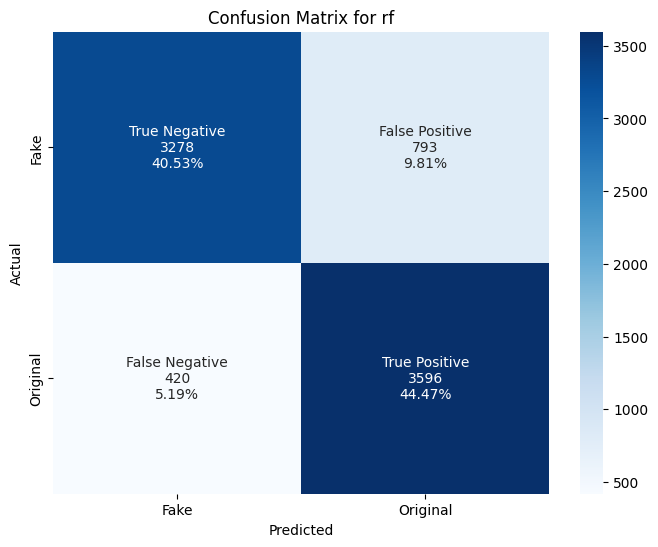

In [231]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier model
rf = RandomForestClassifier()

# Evaluate the model
model_train_evaluate(rf, X_train, y_train, X_test, y_test, "rf")

### Neural Network

In [232]:
# Build and train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


def build_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               4697472   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4705793 (17.95 MB)
Trainable params: 4705793 (17.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [233]:
# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# convert the sparse tensors to dense tensors
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
809/809 [==============================] - 46s 55ms/step - loss: 0.3286 - accuracy: 0.8571 - val_loss: 0.2606 - val_accuracy: 0.8919
Epoch 2/10
809/809 [==============================] - 41s 51ms/step - loss: 0.1867 - accuracy: 0.9241 - val_loss: 0.2620 - val_accuracy: 0.8901
Epoch 3/10
809/809 [==============================] - 41s 51ms/step - loss: 0.1247 - accuracy: 0.9525 - val_loss: 0.2890 - val_accuracy: 0.8889
Epoch 4/10
809/809 [==============================] - 41s 51ms/step - loss: 0.0830 - accuracy: 0.9694 - val_loss: 0.3228 - val_accuracy: 0.8884
Epoch 5/10
809/809 [==============================] - 41s 51ms/step - loss: 0.0533 - accuracy: 0.9804 - val_loss: 0.3732 - val_accuracy: 0.8881
Epoch 6/10
809/809 [==============================] - 41s 51ms/step - loss: 0.0362 - accuracy: 0.9872 - val_loss: 0.4136 - val_accuracy: 0.8862
Epoch 7/10
809/809 [==============================] - 42s 51ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.4619 - val_accuracy:

In [234]:
# Save the model
model.save('nn.h5')

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



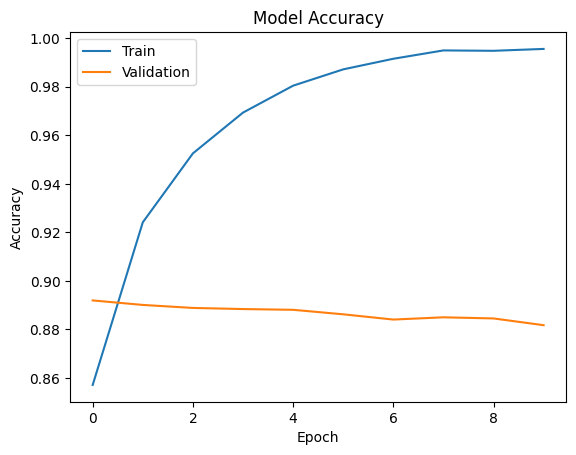

In [235]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

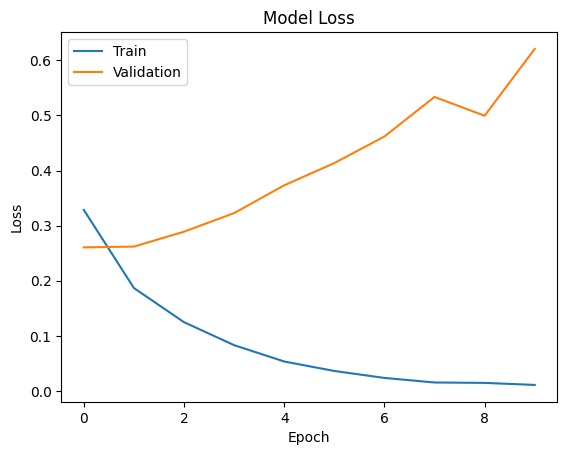

In [236]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

253/253 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      4071
           1       0.86      0.91      0.88      4016

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



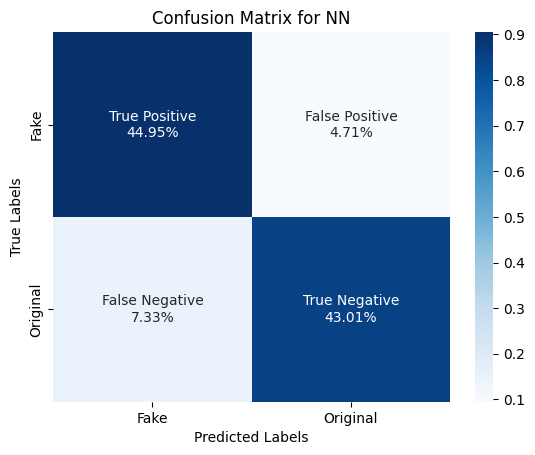

In [237]:
# make confosion matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

# Print the evaluation metrics for the dataset
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
group_names = ["True Positive", "False Positive",
                "False Negative", "True Negative"]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

ax = plt.subplot()
sns.heatmap(cm/cm.sum(axis=1)[:, np.newaxis], annot=labels, ax=ax, cmap="Blues", fmt="")
ax.set_title("Confusion Matrix for NN")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["Fake", "Original"])
ax.yaxis.set_ticklabels(["Fake", "Original"])

plt.show()

### GridSearchCV

You can use this to find the best parameters. I don't use it because it takes too long on my CPU.

In [238]:
# from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
# from sklearn.svm import SVC
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.linear_model import LogisticRegression

# def find_best_model_using_gridsearchcv(x, y):
#     algos = {
#         'svm': {
#             'model': SVC(),
#             'params': {
#                 'C': [0.1, 1],
#                 'kernel': ['linear', 'rbf']
#             }
#         },
#         'multinomial_nb': {
#             'model': BernoulliNB(),
#             'params': {
#                 'alpha': [0.1, 1.0],
#             }
#         },
#         'logistic_regression': {
#             'model': LogisticRegression(),
#             'params': {
#                 'C': [0.1, 1],
#                 'penalty': ['l1', 'l2'],
#             }
#         }
#     }

#     scores = []
#     cv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

#     for algo_name, config in algos.items():
#         gs = RandomizedSearchCV(config['model'], config['params'], cv=cv, n_iter=3, random_state=0, n_jobs=-1, return_train_score=False)
#         gs.fit(x, y)
#         scores.append({
#             'model': algo_name,
#             'best_score': gs.best_score_,
#             'best_params': gs.best_params_,
#             'best_model': gs.best_estimator_
#         })

#     df_scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'best_model'])
#     best_model = df_scores.loc[df_scores['best_score'].idxmax(), 'best_model']

#     return df_scores, best_model

# import warnings
# warnings.filterwarnings('ignore')

# # Call the function to find the best model
# scores, best_model= find_best_model_using_gridsearchcv(X_train, y_train)

# # Save the best model using pickle
# filename = 'best_model.pkl'  # Choose a filename for the saved model
# with open(filename, 'wb') as f:
#     pickle.dump(best_model, f)

In [239]:
# Save all the accuracy scores in a dataframe from SVM, Naive Bayes, Logistic Regression, Decision Tree, Random Forest and Neural Network
scores = pd.DataFrame({'Model': ['SVM', 'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Neural Network'],
                          'Accuracy': [0.88, 0.73, 0.87, 0.75, 0.85, 0.88]})
scores

Model  Accuracy
0                  SVM      0.88
1          Naive Bayes      0.73
2  Logistic Regression      0.87
3        Decision Tree      0.75
4        Random Forest      0.85
5       Neural Network      0.88

# Model Testing

In [240]:
def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)
    
def load_vectorizer(vectorizer_path):
    with open(vectorizer_path, 'rb') as f:
        return pickle.load(f)    

# Load the best model (in this case its logistic regression)
model = load_model('svm.pkl')

# Load the TF-IDF vectorizer
vectorizer = load_vectorizer('vectorizer.pickle')

In [247]:
def predict(texts):
    # Preprocess the text
    cleaned_texts = [preprocess(text) for text in texts]
    
    # Vectorize the text
    texts_vectorized = vectorizer.transform(cleaned_texts)
    
    # Predict the label using the model
    predictions = model.predict(texts_vectorized)

    # Map the predictions to "Fake" or "Original"
    predictions = ['Fake' if pred == 1 else 'Original' for pred in predictions]

    # Create a DataFrame with the text and sentiment predictions
    df = pd.DataFrame({'text': texts, 'label': predictions})
    
    # Return the predictions
    return df

In [249]:
# Max width none to display all columns
pd.set_option('display.max_colwidth', None)

reviews = ["This is the best product I've ever used!",
           "I wouldn't recommend this product to anyone.",
           "It's okay, but there are better options out there.",
           "I'm really impressed with the quality of this product.",
           "This product is a waste of money.",
           "I've been using this product for years and it never disappoints.",
           "I wish I had bought a different product instead.",
           "This product exceeded my expectations.",
           "I'm not sure if I would buy this product again.",
           "I'm so glad I decided to try this product."]


predict(reviews)

text     label
0                          This is the best product I've ever used!      Fake
1                      I wouldn't recommend this product to anyone.      Fake
2                It's okay, but there are better options out there.  Original
3            I'm really impressed with the quality of this product.  Original
4                                 This product is a waste of money.  Original
5  I've been using this product for years and it never disappoints.  Original
6                  I wish I had bought a different product instead.  Original
7                            This product exceeded my expectations.  Original
8                   I'm not sure if I would buy this product again.      Fake
9                        I'm so glad I decided to try this product.      Fake

Make sure its only take review from this category

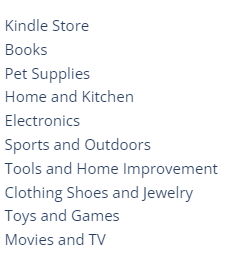